# HMM Training Tutorial

Welcome to the training tutorial! Since Homomorph doesn't have built-in methods for fitting HMMs to data, in this tutorial we'll cover examples of training HMMs where 1) the output distribution is discrete and continuous and 2) the hidden states are both known and unknown using maximum-likelihood criteria. Finally, we'll discuss a more advanced approach called discriminative training. We have a lot of ground to cover, so let's get started!

## 1 What is training?

### 1.1 Training, informally

Training and learning are jargon commonly used in machine learning. While convenient as a shorthand, I feel they're a bit over-used since they obscure what's actually happening: parameter estimation or, more generally, optimization. Statistical models are specified by some number of parameters, so the name of the game is choosing parameters that fit the data the best. Depending on the model, this can be as simple as taking an average or as complex as needing specialized algorithms and thousands of computing hours. Note that the notion of a "best" fit to the data isn't always immediately obvious, and some applications will define it differently. (We'll see at least two distinct definitions in the following examples.) In every case, however, some quantity of interest is defined that is hopefully correlated with the ability to predict real-world outcomes, and then some computational method is used to find parameters that maximize or minimize this quantity.

### 1.2 Training, formally

Now that we understand what training is, let's briefly talk about how it's defined. This section will mainly serve to introduce some terminology that I'll use throughout this tutorial, but it will also highlight the features that are common to all optimization problems regardless of application or mathematical form.

At the core of every optimization problem is a function whose output is optimized with respect to one or more inputs. This is called the *objective function* or simply the *objective*. This terminology is common when discussing optimization generically, and the kind of extremum (minimum or maximum) is unstated. In machine learning and statistics, however, the objective is almost always framed as a kind of distance between the model's output and the actual data. Distance has a very specific meaning in mathematics, so we instead call this quantity *loss*. Naturally, then, the goal is to minimize loss. Unlike in many optimization problems where the optimal value of the objective is as important as the inputs that achieve that optimum, when fitting models the loss is often only a means to an end. Though the loss has applications when comparing the fits of different models, the optimized parameters are typically the ultimate goal.

The form of the loss function depends on the exact nature of the problem, so it's difficult to go any further without speaking in overly general terms. Thus, to illustrate these concepts mathematically, we'll use an extremely common loss function, the mean squared error. Let's now define the data, model, and loss precisely. The data, $D$, is composed of $N$ examples which are the indexed ordered pairs $\{(x_i, y_i):1 \le i \le N\}$. Each $x_i$ and $y_i$ is an input and output, respectively. Though these quantities can be vector-valued, we'll keep our discussion general enough to not have to worry about these details. The model is a function $f$ which accepts an input, $x$, and returns an output, $\hat{y}$. The output is designated with a hat to indicate it was calculated from the model rather than observed. This function also accepts a set of parameters $\theta$ which we can tune to better fit the data. Thus, we can write $\hat{y} = f(x, \theta)$. Finally the loss function, $L$, accepts the data, model, and parameters and returns a measure of the deviation from the data, $L(D, f, \theta)$. For mean squared error, we can write this as

$$
\begin{aligned}
L(D, f, \theta)
&= \frac{1}{N} \sum_{i=1}^N \left( \hat{y}_i - y_i \right)^2 \\
&= \frac{1}{N} \sum_{i=1}^N \left( f(x_i, \theta) - y_i \right)^2
\end{aligned}
$$

In this case, the loss is composed of a sum over individual examples. This is extremely common, so losses are frequently expressed in terms of an individual input and output pair rather than the entire data set. Furthermore, since the data and model are usually fixed, they are often dropped as arguments, making the loss a function of the parameters alone $L(D, f, \theta) = L(\theta)$.

Now we can write our optimized parameters as

$$
\hat{\theta} = \text{argmin}_\theta L(\theta)
$$


Finding these minimum parameters is not always straightforward. For simple models, such as one-dimensional linear regression where $f(x, \theta) = \theta_1 x + \theta_0$, there are closed-form solutions. However, modern machine learning models typically offer no such luxury, so other approaches are needed. There are various techniques for such cases depending on the structure of the model. However, they are all usually iterative in nature, meaning they gradually decrease the loss in a series of small steps. For complex models and large data sets, each one of these steps can involve significant computation, which is why these models are often trained on computational clusters with specialized hardware.

## 2 Training with known states

This is by far the easiest case since all the information is available to us, and depending on the emission distributions, there are even closed-form solutions for the optimal parameters. As HMMs are probabilistic models, we can rely on the rich theory of mathematical statistics to define optimality and identify the corresponding parameters.

### 2.1 Maximum-likelihood estimation

The strength of probabilistic models is that for a given set of parameters, every possible input is associated with a probability or probability density, so objective functions are naturally defined in terms of these quantities. This doesn't answer question of what probability we should try to optimize, however. There are several common approaches, but one of the most natural is to maximize the probability of the data with respect to the parameters. Let's clarify what this means by writing it mathematically. We'll call our data, $D$, a set of indexed observations $\{x_i:1 \le i \le N\}$ and the probability mass function $f(x, \theta) = P(X = x | \theta)$. (The right-hand side translates to "the probability that the random variable called $X$ assumes the value $x$ given the set of parameters $\theta$. In probability, the random processes that generate observations are distinguished from the observations themselves.) The probability of the data is then given as

$$
\begin{aligned}
P(D|\theta)
&= \prod_{i=1}^N P(X = x_i | \theta) \\
&= \prod_{i=1}^N f(x_i, \theta)
\end{aligned}
$$ 

since each observation is independent and identically distributed. Sums are much easier to work with, so it's common to take the logarithm of both sides and call the result $L(\theta) = \sum_{i=1}^N \log f(x_i, \theta)$ the *likelihood function*. Some sources define the original product as the likelihood function, so technically our quantity $L(\theta)$ is the log-likelihood function. However, the logarithm doesn't change the position of the function's extrema, so this distinction is not very important.

Before moving forward, I want to make a few comments about the likelihood function. First, even though we defined it in terms of observations that assume discrete values (notice that $f$ is probability rather than a probability **density**), the definition is the same for continuous observations. The only difference is we can no longer consider the likelihood as a log probability since it is technically a log probability density. However, this not a very common interpretation anyway since even for discrete data the probability of any single sequence of observations approaches 0 as the number of observations increases. It's instead more useful to compare ratios of likelihoods under different models. That, however, is a topic for another time. Another subtle point is that the likelihood function is not the probability that the parameters are correct. We instead view a particular choice of parameters as certain and then calculate the probability of the data given that choice. Finally, as with the meaned squared loss we defined earlier, though the likelihood is technically a function of both the parameters and the data, the data are often dropped as an argument to emphasize that they are typically fixed.

For probabilistic models, this likelihood function is a natural, though not the only, choice for the objective. Unlike with a loss function, we want to maximize the likelihood since this maximizes the probability of the data under the model. This defines the following set of parameters

$$
\hat{\theta} = \text{argmax}_\theta L(\theta)
$$

which are known as *maximum likelihood estimates* (MLEs). Though this objective isn't quite a loss in the sense of a distance from some desired outputs, it's actually very close. Since the model should assign common events high probabilities (and accordingly rare events low probabilities since the total probability is constrained to sum to one), the likelihood in effect penalizes deviations from the empirical distribution. In fact, simply negating the likelihood function converts the maximization into a minimization, making it a kind of loss. However, for some models further manipulations can reveal an algebraic expression which is more readily interpreted as a distance.

Calculus tells us that local extrema are necessarily where the derivative relative to the parameter is zero. If $\theta$ is actually a set of $N$ parameters, this condition must occur simultaneously for the derivative relative to each. In other words,

$$
\frac{\partial L}{\partial \theta_1} = 0, \quad \ldots, \quad \frac{\partial L}{\partial \theta_N} = 0
$$

In some cases these equations can be solved explicitly, but often numerical techniques are needed. We'll see two examples of such approaches in later sections.

### 2.2 Maximum likelihood estimates for HMMs

#### 2.2.1 Decomposition into independent products

Now let's turn to HMMs and derive the MLEs for labeled data. Here the data, $D$, is again composed of $N$ examples of ordered pairs $\{(x_i, y_i)|1 \le i \le N\}$ where $x_i$ is a sequence of states and $y_i$ is a sequence of emissions, each with length $T_i$. The probability of the data is then given by

$$
\begin{aligned}
P(D|\theta)
&= \log P(X_1=x_1, Y_1=y_1, \ldots, X_N=x_N, Y_N=y_N|\theta) \\
&= \prod_{i=1}^N P(X_i=x_i, Y_i=y_i|\theta) \\
\end{aligned}
$$

The joint probability expands into a product of the probabilities of individual examples since each is independent and identically distributed. Let's now focus on one pair of state and emission sequences denoted $x$ and $y$, each with length $T$. Using the Markov property of HMMs, we can derive an expression for the joint probability of the state and emission sequences. Note that here when we use subscripts, we're referring to the index **within** a sequence rather than the index of the example.

$$
P(X=x, Y=y|\theta)
= P(Y_1=y_1|X_1=x_1,\theta) P(X_1=x_1|\theta)
  \prod_{t=1}^{T-1} P(Y_{t+1}=y_{t+1}|X_{t+1}=x_{t+1},,\theta) P(X_{t+1}=x_{t+1}|X_t=x_t,\theta)
$$

All these capital letters are making this expression a little busy, so let's be looser with our notation and drop them for now. In essence, we're making the subsitution $P(X=x) = P(x)$, so we'll keep in mind the latter means the probability of the random variable $X$ assuming the value $x$.

$$
P(x, y|\theta)
= P(y_1|x_1, \theta) P(x_1|\theta)
  \prod_{t=1}^{T-1} P(y_{t+1}|x_{t+1}, \theta) P(x_{t+1}|x_t, \theta)
$$

We will now assume there are $S$ states numbered from $1$ to $S$ and $P(X_{t+1}=j|X_t=i) = a_{ij}$, $P(X_1=j) = a_{0j}$. We can then define the following quantity which counts the number of transitions between states

$$
n_{ij} = \sum_{t=1}^{T-1} \delta_{jx_{t+1}} \delta_{ix_t}
$$

where $\delta_{ij}$ is the Kronecker delta function defined as

$$
\delta_{ij} = 
\begin{cases}
    0 &\text{if } i \neq j \\
    1 &\text{if } i=j
\end{cases}
$$

Similarly, we'll define a variable that counts the number of times each state starts the state sequence. For a single example, one of these is equal to one and all others are zero.

$$
n_{0i} = \delta_{ix_1}
$$

Finally, we'll simplify the notation further by defining $b_i(y) = P(y|x=i, \theta)$. We can think of each $b_i$ as a function that accepts an emission and outputs a probability or probability density.

Inspecting the previous equation shows we can write it in terms of the quantities we just defined. (We'll also define $0^0=1$ to ensure the expression is valid for forbidden start states or transitions.)

$$
\begin{aligned}
P(x, y|\theta)
&= P(y_1|x_1, \theta) P(x_1|\theta) \prod_{t=1}^{T-1}
   P(y_{t+1}|x_{t+1}, \theta) P(x_{t+1}|x_t, \theta) \\
&= \left( \prod_{i=1}^S a_{0i}^{n_{0i}} \right)
   \left( \prod_{i=1}^S \prod_{j=1}^S a_{ij}^{n_{ij}} \right)
   \left( \prod_{i=1}^S \prod_{t=1}^T b_i(y_t) \delta_{iy_t} \right)
\end{aligned}
$$

While this looks extremely complicated, it's the same product of the probabilities of each start state, transition, and emission. However, when it's written in this form, it's clear that each of these products is independent from the others, meaning they have no parameters in common. In fact, the transition product can be further decomposed into independent products, one for each initial state. Additionally, if the emission distributions do not share parameters, they too can be decomposed into independent products for each state. This dramatically simplifies the optimization since to maximize the probability of the entire expression, we can maximize each product separately. Furthermore, although we've derived this expression for a single pair of state and emission sequences, the form is identical for the data as a whole. The only difference is the counts are taken over all state sequences and the emission product is taken over all emission sequences.

#### 2.2.2 MLEs for categorical distributions

Now that we've broken the maximization problem into a set of simpler problems, let's review the solutions for each. The optimal parameters for the emissions will depend on their distribution, but the start and transition distributions always take the form of a single choice from a set of options. This is formally called a *categorical distribution* which itself is a special case of the *multinomial distribution*. Fortunately, the MLEs for categorical distributions have a simple form. The derivation is somewhat involved, so I'll only show the formula. Using the count variables we defined earlier, the MLE for each $a_{ij}$ is given as

$$
\hat{a}_{ij} = \frac{n_{ij}}{\sum_{j=1}^S n_{ij}}
$$

The interpretation is intuitive. Our estimate of the probability of state $i$ transitioning to state $j$ is simply the fraction of times we observe this in the data! One problem with this equation, however, is if we're working with a relatively small amount of data, we may never observe a certain transition and estimate its transition probability as 0. This means according to the model the transition is impossible, which may be contrary to our conception of the underlying process generating the data. In these cases, it's customary to add a small non-negative correction factor, $r_{ij}$, for each pair of states.

$$
\hat{a}_{ij} = \frac{n_{ij} + r_{ij}}{\sum_{j=1}^S n_{ij} + r_{ij}}
$$

These corrections may look like a sloppy fix, but they actually have a natural Bayesian interpretation as the parameters of a Dirichlet prior on the transition probabilities. What this means in practice is the size of each $r_{ij}$ reflects our prior expectation for the probability of that transition, with larger values indicating more certainty.

### 2.3 Examples

Now that we've covered the basic theory of HMM parameter estimation, let's use it on some examples. We'll first write code to estimate the parameters for an HMM with a categorical emission distribution since we've already reviewed the MLEs in the previous section. We'll then use the principle of maximum-likelihood to derive the estimators for other common emission distributions and write implementations from scratch.

#### 2.3.1 Categorical emission distribution

To get started, let's first import the packages we'll use.

In [1]:
import homomorph
import matplotlib.pyplot as plt

Now let's create our HMM. Since the purpose of this tutorial is to illustrate training techniques rather than motivate the applications of HMMs with relevant examples, we'll arbitrarily label the states with numbers and emissions with letters.

In [2]:
t_dists = {1: {1: 0.9, 2: 0.1},
           2: {1: 0.05, 2: 0.7, 3: 0.25},
           3: {2: 0.5, 3: 0.5}}
e_dists = {1: {'A': 1},
           2: {'A': 0.5, 'B': 0.5},
           3: {'B': 1}}
start_dist = {1: 0.2, 2: 0.5, 3: 0.3}

model = homomorph.HMM(t_dists=t_dists, e_dists=e_dists, start_dist=start_dist)
model

HMM(states={1, 2, 3},
    stop_states=[],
    name='hmm')

Let's now generate 10 examples each with length 100. The simulations are generated as a single sequence of (state, emission) pairs. However, since in the theory section we defined separate state and emission sequences, we'll do a bit of Python magic to put the data in this form.

In [3]:
data = [model.simulate(100, random_state=i) for i in range (10)]  # Use a different random seed for each example
print('Original form:', data[0][:5])
data = [list(zip(*example)) for example in data]
print('New form:', [seq[:5] for seq in data[0]])

Original form: [(2, 'A'), (1, 'A'), (1, 'A'), (1, 'A'), (1, 'A')]
New form: [(2, 1, 1, 1, 1), ('A', 'A', 'A', 'A', 'A')]


Let's take a look at one of these examples.

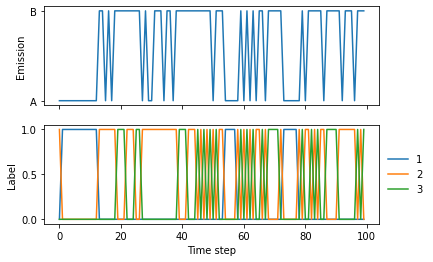

In [10]:
xs, ys = data[0]
lines = {}
for state in t_dists:
    lines[state] = [x == state for x in xs]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(ys)
for state, line in sorted(lines.items()):
    axs[1].plot(line, label=state)
axs[1].set_xlabel('Time step')
axs[0].set_ylabel('Emission')
axs[1].set_ylabel('Label')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

Now let's implement the MLEs for the transition probabilities. Before, though, we should discuss selection of the model structure, that is, the number of states and the allowed transitions between those states. Since in this case the data is simulated, we know the structure exactly. However, real-world data are often far more complicated since it's rare to have perfect knowledge of the underlying process that generated the data even if they are labeled. That said, constraining the allowed transitions can lead to better models, particularly if the constraints reflect a feature of the data generating process.

For this example, we'll assume that we have some "domain knowledge" that permits us to know the states and their allowed transitions. For example, state 2 can transition to every state, but states 1 and 3 can only transition to themselves and state 2. We'll also add a small pseudocount for the allowed transitions to ensure they're permitted by our model in the extremely rare chance that we don't observe them in the data. There are a variety of ways to implement this, but in the approach shown below we'll start by instantiating a transition count dictionary with the pseudocounts. We'll then iterate over the data to add the observed transitions. Finally, we'll normalize the counts by the total number for each initial state to obtain the estimated transition probabilities.

The benefit of this approach is it yields a nested dictionary which we can use as an input to the `HMM` class. We'll actually use the original `t_dists` to establish the model structure, but if it weren't available, we could create a similar nested object which encodes the same information. (Unfortunately, it's hard to avoid specifying at least some portions of the model manually unless it's fully-connected or its structure is highly modular.)

In [11]:
# Make transition count dicts and add pseudocounts
t_pseudo = 0.1
t_counts = {}
for state1, t_dist in t_dists.items():
    t_count = {}
    for state2 in t_dist:
        t_count[state2] = t_pseudo
    t_counts[state1] = t_count

# Add observed counts
for example in data:
    xs, ys = example
    state0 = xs[0]
    for state1 in xs[1:]:
        t_counts[state0][state1] += 1
        state0 = state1

# Normalize counts
t_dists_hat = {}
for state1, t_count in t_counts.items():
    t_sum = sum(t_count.values())
    t_dist_hat = {}
    for state2, count in t_count.items():
        t_dist_hat[state2] = count / t_sum
    t_dists_hat[state1] = t_dist_hat
t_dists_hat

{1: {1: 0.9098053892215568, 2: 0.09019461077844312},
 2: {1: 0.057992724160068475, 2: 0.6828589771025037, 3: 0.25914829873742773},
 3: {2: 0.4804839968774395, 3: 0.5195160031225605}}

So far so good! The estimated transition probabilities are extremely close to their actual values.

Let's now estimate the emission probabilities. Since the emission distributions are also categorical, the code has nearly the same structure. However, let's make a small change to illustrate some of the choices inherent in model selection. Although we assumed we knew the states and allowed transitions perfectly, let's say this isn't true for the emissions. For example, even though we never observe states 1 and 3 emitting an A and B, respectively, we still aren't 100% convinced that it's impossible. Thus, we'll first gather all the possible emission types from the data and instantiate the emission distributions with a small pseudocount for each type. From there, the code is largely the same.

In [6]:
# Collect all possible emissions
e_set = set()
for example in data:
    xs, ys = example
    e_set.update(*ys)

# Make emission count dicts and add pseudocounts
e_pseudo = 0.1
e_counts = {}
for state in t_dists:
    e_counts[state] = {emit: e_pseudo for emit in e_set}

# Add observed counts
for example in data:
    xs, ys = example
    for state, emit in zip(xs, ys):
        e_counts[state][emit] += 1

# Normalize counts
e_dists_hat = {}
for state, e_count in e_counts.items():
    e_sum = sum(e_count.values())
    e_dist_hat = {}
    for emit, count in e_count.items():
        e_dist_hat[emit] = count / e_sum
    e_dists_hat[state] = e_dist_hat
e_dists_hat

{1: {'B': 0.00036873156342182885, 'A': 0.9996312684365781},
 2: {'B': 0.5423549343498517, 'A': 0.4576450656501482},
 3: {'B': 0.9996111975116639, 'A': 0.0003888024883359253}}

Again the estimates are very close!

Finally let's do the start distribution. The overall idea is exactly the same, except now we're working with a single distribution rather than a dictionary of distributions. As a note, we can only estimate the start distribution from the initial state of each example. Since this severely limits the amount of data relative to the transitions, it may be tempting to use the state counts over all time points instead. Technically, this quantity will estimate the equilibrium distribution of the underlying Markov process, which is a function of the transition probabilities and independent from the start distribution. However, there may be data-specific reasons to think these quantities are equal, so this is again an example of a model selection decision.

In [7]:
# Make start count dicts and add pseudocounts
start_pseudo = 0.1
start_count = {}
for state in start_dist:
    start_count[state] = start_pseudo

# Add observed counts
for example in data:
    xs, ys = example
    start_count[xs[0]] += 1

# Normalize counts
start_sum = sum(start_count.values())
start_dist_hat = {}
for state, count in start_count.items():
    start_dist_hat[state] = count / start_sum
start_dist_hat

{1: 0.10679611650485439, 2: 0.5922330097087379, 3: 0.3009708737864078}

We're now ready to combine all these individual parameter estimates into our estimated model.

In [8]:
model_hat = homomorph.HMM(t_dists=t_dists_hat, e_dists=e_dists_hat, start_dist=start_dist_hat)
model_hat

HMM(states={1, 2, 3},
    stop_states=[],
    name='hmm')

Though the estimates match the parameters closely, to really see how well they compare, let's make some predictions using both. We'll use posterior decoding to obtain a distribution over states at each time step since this will give us a more nuanced picture of how each model interprets the data.

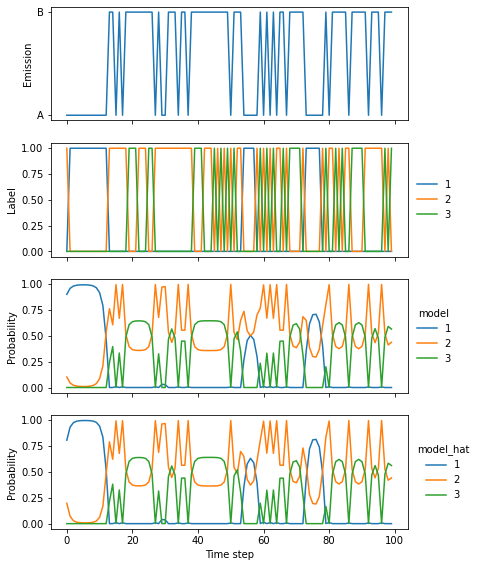

In [9]:
xs, ys = data[0]
fbs = model.forward_backward(ys)
fbs_hat = model_hat.forward_backward(ys)

fig, axs = plt.subplots(4, 1, figsize=(6.4, 9.6), sharex=True)

axs[0].plot(ys)
for state, line in sorted(lines.items()):
    axs[1].plot(line, label=state)
for state, line in sorted(fbs.items()):
    axs[2].plot(line, label=state)
for state, line in sorted(fbs_hat.items()):
    axs[3].plot(line, label=state)
axs[3].set_xlabel('Time step')
axs[0].set_ylabel('Emission')
axs[1].set_ylabel('Label')
axs[2].set_ylabel('Probability')
axs[3].set_ylabel('Probability')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
axs[2].legend(title='model', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
axs[3].legend(title='model_hat', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

The posterior decoding curves are effectively identical. There are, of course, some minor differences but no real patterns that I can see. Generally these models are good at detecting the time steps corresponding to state 1 but much worse at distinguishing between states 2 and 3. We can understand this qualitatively by examining the original model parameters. State 1 is highly "sticky" and only emits As, so long runs of As are extremely likely to correspond to state 1. State 3 only emits Bs, but it's just as likely to switch to state 2 as it is to remain in state 3. Additionally, state 2 is equally likely to emit an A as a B, so it's difficult to know if a B was emitted because the model remained in state 3 or because it switched to state 2. This shows that state inference can be highly variable even if the parameters are known exactly.

#### 2.3.2 Discrete emission distribution

#### 2.3.3 Continuous emission distribution

## 3 Training with unknown states

### 3.1 Estimation-maximization

- Discuss informally
- Give Baum-Welch algorithm for finite emissions
- Introduce EM algorithm
- Use EM to derive equation for more complex distribution

### 3.2 Examples

Baum-Welch algorithm for same examples as in known labels

## 4 Discriminative training

Discriminative training should really fall under the heading of training with known states since. However, there are enough differences in the objective function and the optimization algorithm that it deserves its own section.

### 4.1 Discriminative training theory

Adapt presentation of theory from reference paper

### 4.2 Example

Some complex, real-world data with discriminative training